- http://hgdownload.soe.ucsc.edu/goldenPath/hg38/liftOver/

In [1]:
import sys
import os
from os import path,listdir
import subprocess
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import re 
import gzip
import pygraphviz
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import gc

In [2]:
##################################
### General methods
##################################

def Call(s):
    subprocess.call(s, shell=True, executable='/bin/bash')
    
    
def bed_sort(input_file):
    call = "sort -k1,1 -k2,2n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
    
    
def gtf_sort(input_file):
    call = "sort -k1,1 -k4,4n -o '%s' '%s'"%(input_file,input_file)    
    Call(call)
        
        
def microparser(line):
    if len(line.strip())==0:
        return None
    X = line.strip().split('\t')        
    r = {a.split(' ')[0]:a.split(' ')[1].replace('"','') for a in [x.strip() for x in X[8].split(';') if len(x.strip())>0]}
    r.update({'chr':X[0],'start':X[3],'end':X[4],'strand':X[6],'feature':X[2]})
    return r


def parse_meta(text):
    assembly = re.findall('human genome \((.*)\),',text)[0].strip()
    version = re.findall('version (.*) \(',text)[0].strip()
    ensembl = re.findall('Ensembl (.*)\)',text)[0].strip()
    _date = re.findall('date: (.*)',text)[0].strip()
    return {'gencode':version,'assembly':assembly,'ensembl':ensembl,'date':_date}

##################################
### Download gencode
##################################

def download_gencode(output_raw_path,output_gene_path,output_meta_path,max_version=41):
    for folder in [output_raw_path,output_gene_path,output_meta_path]:
        if not path.exists(folder):
            os.makedirs(folder)
    call_download = """wget "ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_{version}/gencode.v{version}.annotation.gtf.gz" -P {output_raw_path}
zgrep -P "\\tgene\\t" {output_raw_path}/gencode.v{version}.annotation.gtf.gz | sort -k1,1 -k4,4n | gzip > {output_gene_path}/v{version}.gtf.gz
zcat {output_raw_path}/gencode.v{version}.annotation.gtf.gz | head -n 5 > {output_meta_path}/v{version}.txt
"""
    versions = list(range(5,max_version+1))
    for version in versions:
        output_gene = path.join(output_gene_path,'v%d.gtf.gz'%version)
        if path.exists(output_gene):
            print('# Already processed',output_gene)
            continue
        call = call_download.format(version=version,output_raw_path=output_raw_path,
                                    output_gene_path=output_gene_path,output_meta_path=output_meta_path)
        print(call)
        Call(call)
        

##################################
### Create files for index
##################################

def create_equivalence_table(output_meta_path,output_ensembl_equivalence):
    files = sorted([path.join(output_meta_path,x) for x in listdir(output_meta_path) if x.startswith('v') and x.endswith('.txt')])
    rows = []
    for input_file in files:
        with open(input_file,'r') as f:
            text = ''.join(f.readlines()).replace('\n',' ').strip()
        rows.append(parse_meta(text))
    df = pd.DataFrame(rows).sort_values(by=['date'],ascending=[False])
    df = df[['gencode','ensembl','assembly','date']]
    df.to_csv(output_ensembl_equivalence,index=None)
    print('# Wrote',output_ensembl_equivalence)    
    
    
def create_gene_index(output_gene_path,output_gene_index,max_version=41):
    files = sorted([path.join(output_gene_path,x) for x in listdir(output_gene_path) if x.endswith('.gtf.gz')])
    fields = ['gene_id','gene_name','gene_type','hgnc_id']
    rows = []
    for input_file in files:
        version = int(re.findall('v(.*)\.gtf\.gz',input_file)[0])
        print("Reading",input_file)
        with gzip.open(input_file,'rt') as f:
            for line in f:
                e = microparser(line)
                d = {x:e.get(x,None) for x in fields}
                d['gencode'] = version
                d['gene_shortid'] = d['gene_id'].split('.')[0]
                if 'PAR_Y' in d['gene_id']:
                    d['gene_shortid']+='_PAR_Y'
                coord = '%s:%s-%s(%s)'%(e['chr'],e['start'],e['end'],e['strand'])
                d['coord'] = coord
                rows.append(d)
    df = pd.DataFrame(rows)
    df = df[['gene_shortid','gencode','coord']+fields]
    df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False],inplace=True)

    ## Find deprecated IDs by checking where is the last version they were used.
    deprecated = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False]).drop_duplicates(subset=['gene_shortid'],keep='first').copy()
    deprecated = set(deprecated[deprecated['gencode']<max_version].gene_shortid)
    df['deprecated'] = df['gene_shortid'].apply(lambda x:int(x in deprecated))
        
    df.to_csv(output_gene_index,index=None,compression='gzip')
    print('# Wrote',output_gene_index)

In [3]:
CURRENT_VERSION = 41
output_download_path = '/mnt/d/GENCODE'
output_raw_path = path.join(output_download_path,'raw')
output_gene_path = path.join(output_download_path,'genes')
output_meta_path = path.join(output_download_path,'metadata')
output_temp = path.join(output_download_path,'temp')

output_index_path = path.join(output_download_path,'index')
output_ensembl_equivalence = path.join(output_index_path,'ensembl_equivalence.csv')
output_gene_index = path.join(output_index_path,'gene_index.csv.gz')
output_graph_index = path.join(output_index_path,'gene_network.pickle')

# chain_hg19_hg38 = path.abspath(path.join('chains','hg19ToHg38.over.chain.gz'))
# temp_pre20_hg19 = path.join(output_temp,'pre20.hg19.bed')
# temp_pre20_hg38 = path.join(output_temp,'pre20.hg38.bed')
# temp_post20_hg38 = path.join(output_temp,'post20.hg38.bed')
# temp_genes = path.join('genes.hg38.bed')
# temp_all_hg38 = path.join(output_temp,'all.hg38.bed')
# temp_o_hg19 = path.join(output_temp,"o.hg19")
# temp_o_hg38 = path.join(output_temp,"o.hg38")
# temp_inter = path.join(output_temp,'intersections.tsv')
# temp_edges = path.join(output_temp,'edges.tsv')


# for folder in [output_index_path,output_temp]:
#     if not path.exists(folder):
#         os.makedirs(folder)

# download_gencode(output_raw_path,output_gene_path,output_meta_path,max_version=CURRENT_VERSION)
# create_equivalence_table(output_meta_path,output_ensembl_equivalence)
# create_gene_index(output_gene_path,output_gene_index,max_version=CURRENT_VERSION)

In [4]:
## Parse gene index and prepare 1) length dictionary and 2) for bed files
# df = pd.read_csv(output_gene_index)
# df['chr'] = df['coord'].apply(lambda x:x.split(':')[0])
# df['start'] = df['coord'].apply(lambda x:int(x.split(':')[1].split('-')[0])-1)
# df['end'] = df['coord'].apply(lambda x:int(x.split('-')[1].split('(')[0]))
# df['strand'] = df['coord'].apply(lambda x:x[-2])
# df['score']=0
# df['id'] = df.apply(lambda x:x['gene_shortid']+'|'+str(x['gencode']),axis=1)
# df['length'] = df['end']-df['start']
# L = df[['id','length']].drop_duplicates().set_index('id')['length'].to_dict()


## Create bed files for liftOver and intersections
# dfx = df[df['gencode']<=19][['chr','start','end','id','score','strand']].sort_values(by=['chr','start','id'])
# dfx.to_csv(temp_pre20_hg19,sep='\t',index=None,header=None)
# print('Wrote',temp_pre20_hg19)
# dfx = df[df['gencode']>19][['chr','start','end','id','score','strand']].sort_values(by=['chr','start','id'])
# dfx.to_csv(temp_post20_hg38,sep='\t',index=None,header=None)
# print('Wrote',temp_post20_hg38)

## LiftOver hg19 to hg38 of gencode<=19
# call = "liftOver -multiple %s %s %s %s.unmapped"%(temp_pre20_hg19,chain_hg19_hg38,temp_pre20_hg38,temp_pre20_hg38)
# print(call)
# Call(call)

## Combine all gene coordinates in hg38
# call = "cat %s %s | sort -k1,1 -k2,2n > %s "%(temp_pre20_hg38,temp_post20_hg38,temp_all_hg38)
# print(call)
# Call(call)

## Intersect from gencode v5 to gencode v19 in native hg19
# call = """intersectBed -sorted -s -wo -a %s -b %s | \
# awk 'BEGIN{OFS=FS="\\t"}{if($4 != $10) print $4"|"$10,  $13}' | \
# sort -k1,1 | \
# bedtools groupby -g 1 -c 2 -o sum > \
# %s
# """

# call1 = call%(temp_pre20_hg19,temp_pre20_hg19,temp_o_hg19)
# print(call1)
# Call(call1)

## Intersect lifted over gencode to hg38 with native hg38 (20 and onwards)
# call1 = call%(temp_all_hg38,temp_post20_hg38,temp_o_hg38)
# print(call1)
# Call(call1)

## Combine intersections
# call = "cat %s %s > %s "%(temp_o_hg19,temp_o_hg38,temp_inter)
# print(call)
# Call(call)

## Prepare tsv with edges (short gene id 1, short gene id 2, overlap of g1, gencode version of g1, gencode version of g2)
# with open(temp_inter,'r') as f, open(temp_edges,'w') as of:
#     for line in f:
#         x = line.strip().split('\t')
#         LI = int(x[1])
#         g1,v1,g2,v2 = x[0].split('|')                
#         id1 = g1+'|'+v1
#         id2 = g2+'|'+v2
#         o1 = round(LI/L[id1],2)
#         o2 = round(LI/L[id2],2)
#         of.write('\t'.join(map(str,(g1,g2,o1,v1,v2)))+'\n')
#         of.write('\t'.join(map(str,(g2,g1,o2,v2,v1)))+'\n')
# print(temp_edges)

## Remove duplicated edges
# call = "sort -u %s -o %s"%(temp_edges,temp_edges)
# print(call)
# Call(call)

# # Only select genes in their first and last version
# df = pd.read_csv(output_gene_index)
# x1 = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,False]).drop_duplicates(subset=['gene_shortid'],keep='first')
# x2 = df.sort_values(by=['gene_shortid','gencode'],ascending=[True,True]).drop_duplicates(subset=['gene_shortid'],keep='first')
# dfg = pd.concat((x1,x2)).drop_duplicates()
# valid_genes = set(dfg[['gene_shortid','gencode']].itertuples(index=False, name=None))

# # Load edges and filter by selected gene versions
# dfe = pd.read_csv(temp_edges,sep='\t',header=None)
# ### dfe = dfe[dfe[0]!=dfe[1]] #This is not desired on genes that have not been mapped to others.
# dfe['valid'] = dfe.apply(lambda x:int(((x[0],x[3]) in valid_genes) and ((x[1],x[4]) in valid_genes)),axis=1)
# dfe = dfe[dfe['valid']==1]

# # Index edges and vertices 
# E = dfe.apply(lambda x:((x[0],x[3]),(x[1],x[4]),{'label':x[2]}),axis=1).to_list()
# V = valid_genes
# genes = {}
# for x in valid_genes:
#     if x[0] not in genes:
#         genes[x[0]] = [x]
#     else:
#         genes[x[0]].append(x)

# # Create and store graph
# G = nx.DiGraph(genes=genes)
# G.add_nodes_from(V)
# G.add_edges_from(E)
# nx.write_gpickle(G,output_graph_index)
# print('# Wrote',output_graph_index)

---
# Load graph

In [5]:
G = nx.read_gpickle(output_graph_index)
E_FW = []
E_RV = []
for e in G.edges():
    if e[0][1] <= e[1][1]:
        E_FW.append(e)
    else:
        E_RV.append(e)
G_FW = nx.DiGraph()
G_FW.add_nodes_from(G.nodes())
G_FW.add_edges_from(E_FW)

G_RV = nx.DiGraph()
G_RV.add_nodes_from(G.nodes())
G_RV.add_edges_from(E_RV)

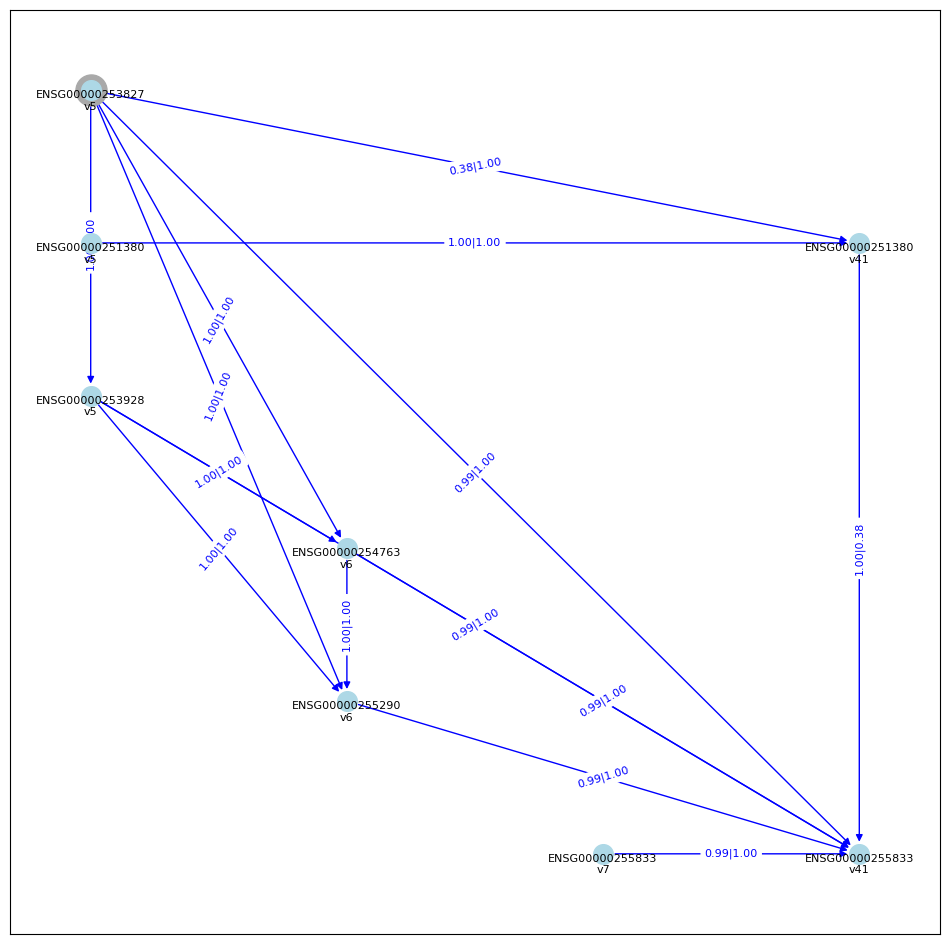

In [169]:
gene_id = 'ENSG00000253827'
# gene_id = 'ENSG00000254100'
root = gene_id
overlap_thr = 0.2

## DFS to find mapping subgraph
GS = set()
for x in G.graph['genes'][gene_id]:    
    GS |= set(dfs_tree(G_FW,x).nodes())
    GS |= set(dfs_tree(G_RV,x).nodes())    
gs = G.subgraph(GS).copy()

### Assign order to genes and versions
_genes = []
_versions = []
for n in gs.nodes():
    _genes.append(n[0])
    _versions.append(n[1])
_genes = [root] + sorted(set(_genes)-set([root]))
_versions = sorted(set(_versions))
_genes_idx = {x:idx for idx,x in enumerate(_genes)}
_versions_idx = {x:idx for idx,x in enumerate(_versions)}

### Get labels for nodes
nodelist = gs.nodes()
node_labels = {x:'%s\nv%d'%(x[0],x[1]) for x in nodelist}
x = pd.DataFrame(nodelist)
latest = set(x.sort_values(by=[0,1],ascending=[True,False]).drop_duplicates(subset=0,keep='first').itertuples(index=None,name=None))
#with_

### Get labels for edges. Remove redundant edges
edgeattr = {x:nx.get_edge_attributes(gs,'label')[x] for x in gs.edges()}
edgelist=[]
edge_labels = {}
for e in gs.edges():
    ## Edge must go from older to newer version
    if e[0][1] > e[1][1]:
        continue
    ## Apply mutual overlap filter
    if edgeattr[(e[0],e[1])]<overlap_thr or edgeattr[(e[1],e[0])]<overlap_thr:
        continue
    if e[1] in latest:
        ## Must go from oldest to latest in same gene
        if (e[0][0]==e[1][0]) or ((e[0] in latest and e[1] in latest) and not (_genes_idx[e[0][0]] > _genes_idx[e[1][0]])):
            edgelist.append(e)
            edge_labels[e] = "%.2f|%.2f"%(edgeattr[(e[0],e[1])],edgeattr[(e[1],e[0])])
# print(latest)
# print('\n'.join(map(str,edgelist)))
gs = nx.DiGraph()
gs.add_edges_from(edgelist)
nodelist = gs.nodes()

###After reducing the graph by filtering, recompute layout
_genes = []
_versions = []
for n in gs.nodes():
    _genes.append(n[0])
    _versions.append(n[1])
_genes = [root] + sorted(set(_genes)-set([root]))
_versions = sorted(set(_versions))
_genes_idx = {x:idx for idx,x in enumerate(_genes)}
_versions_idx = {x:idx for idx,x in enumerate(_versions)}


### Init figure
fig,ax = plt.subplots(figsize=(12,12),dpi=100)

### Manual position
pos = {}
for x in gs.nodes():
    pos[x] = (_versions_idx[x[1]],_genes_idx[x[0]])

# pos = graphviz_layout(gs, prog='neato')
# pos = graphviz_layout(gs, prog='twopi')
# pos =graphviz_layout(gs, prog='dot')
# pos =graphviz_layout(gs, prog='circo')



nx.draw_networkx_nodes(gs, pos, nodelist=[x for x in G.graph['genes'][root]],node_color='darkgray',node_size = 500)
nx.draw_networkx_nodes(gs, pos, nodelist=nodelist,node_color='lightblue',node_size = 200)
nx.draw_networkx_labels(gs, pos, labels=node_labels, verticalalignment='top',font_weight='normal',font_size=8)

# connectionstyle='angle3,angleA=90,angleB=0'
#connectionstyle='arc3,rad=0.2'
# connectionstyle='bar,angle=90,fraction=-.3'
# connectionstyle='arc3'
nx.draw_networkx_edges(gs, pos, edgelist=edgelist,edge_color='blue',arrows=True)
nx.draw_networkx_edge_labels(gs,pos,edge_labels=edge_labels,font_color='blue',font_size=8)

ax.set_ylim(ax.get_ylim()[::-1])
plt.show()